# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import libraries

In [2]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import pysal as ps
import seaborn as sns
import shapely

import statsmodels.api as sm
import matplotlib.pylab as plt

from geopandas import GeoDataFrame
from pandas import DataFrame
from fiona.crs import from_epsg
from matplotlib import colors
%matplotlib inline

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [5]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('Total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

Total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

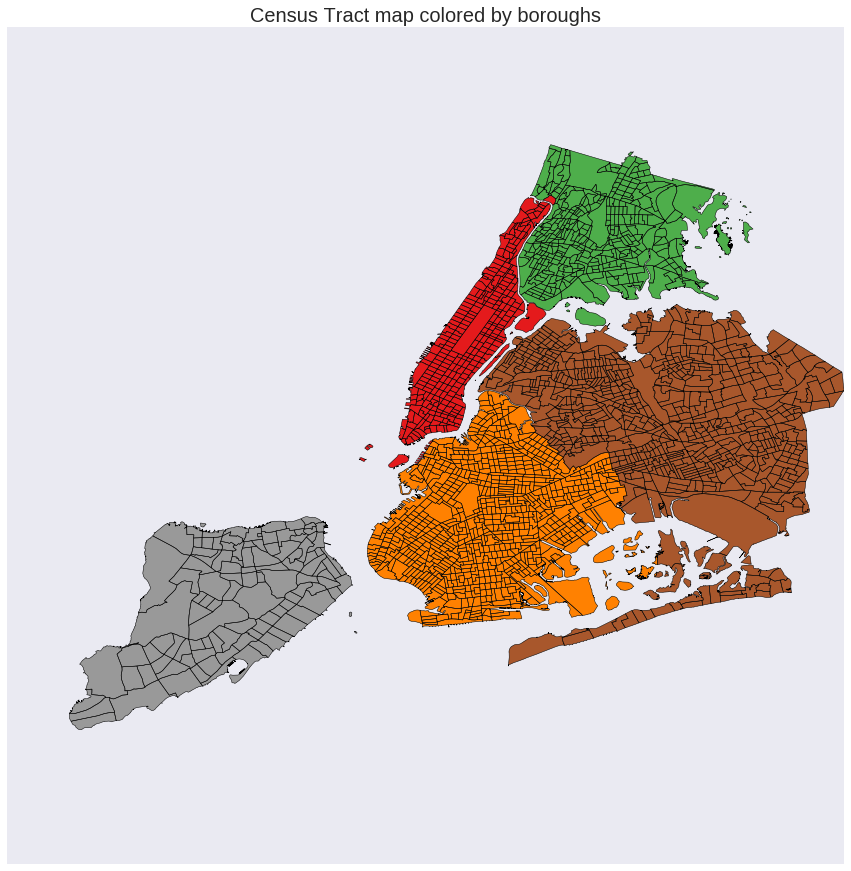

In [14]:
f, ax = plt.subplots(figsize=(15, 15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column = 'BoroCode', alpha = 1, linewidth = 0.5, ax = ax)
plt.title("Census Tract map colored by boroughs", size = 20)

**Figure 1:** Map of Census Track of New York City colorored by boroughs.

### Map NYC Population density

#### Load Census Data for 2010

In [11]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [12]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

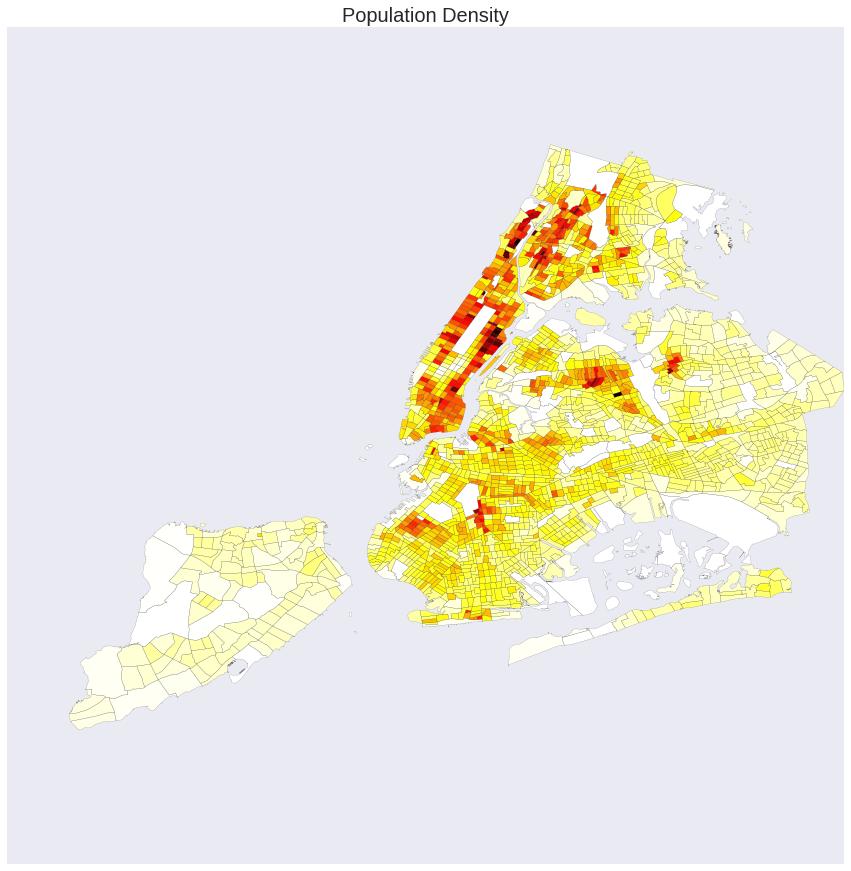

In [16]:
f, ax = plt.subplots(figsize=(15, 15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density", size = 20)

** Figure 2: Map of population density.** The map shows the density of population in New York City. It can be seen that the area which are more dense are in in Manhattan. The area of the Upper East Side and some areas of the Bronx. Contrarly, Staten Island is the area with less density.

## Explore CitiBike data

### Load CitiBike data

In [18]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
bike_monthly = df_bike_monthly.copy()
bike_monthly.head(2)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# This is to create a column only with month to divide the set.

months = []
for i in bike_monthly.index:
    months.append(i.month)
bike_monthly['month'] = months

In [29]:
# summer is contains July, August, September. 
# Oficially, summer starts on 21th June, reason why I decide not to include it and keep September.  

summer_bike_monthly = bike_monthly[(bike_monthly.month>6)&(bike_monthly.month<10)]

In [30]:
summer_bike_monthly

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,month
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,7
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,8
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,9
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,7
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,8
2014-09-30,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,0,9
2015-07-31,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,0,7
2015-08-31,2640,3799,11801,4288,7031,5417,2470,6306,4583,2838,...,0,0,0,0,0,0,0,0,0,8
2015-09-30,3115,4161,11291,4357,7282,6293,2648,6477,5061,2993,...,0,0,0,0,0,0,0,0,0,9


In [23]:
# winter contains January, February and March. 
# Oficially, winter starts on 20th December, I don't think I am loosing so many rides.

winter_bike_monthly = bike_monthly[(bike_monthly.month <4)]
#winter_bike2 = bike_monthly[(bike_monthly.month >10)]
#winter_bike_monthly = winter_bike1.append(winter_bike2)

In [24]:
winter_bike_monthly

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,month
starttime,,,,,,,,,,,,,,,,,,,,,
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,1
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,2
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,3
2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,619,...,0,0,0,0,0,0,0,0,0,1
2015-02-28,562,0,2130,913,1363,1140,356,1023,891,447,...,0,0,0,0,0,0,0,0,0,2
2015-03-31,1012,0,3574,1401,2201,2047,617,1867,1505,769,...,0,0,0,0,0,0,0,0,0,3
2016-01-31,1031,1669,4533,1847,2304,1943,656,2485,0,935,...,0,0,0,0,0,0,0,0,0,1
2016-02-29,1200,1951,4913,2088,2503,2224,859,2814,0,1082,...,0,0,0,0,0,0,0,0,0,2
2016-03-31,1891,3181,7721,2529,4586,3692,1633,4015,0,1894,...,0,0,0,0,0,0,0,0,0,3


### Time Series Analysis - Summer

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


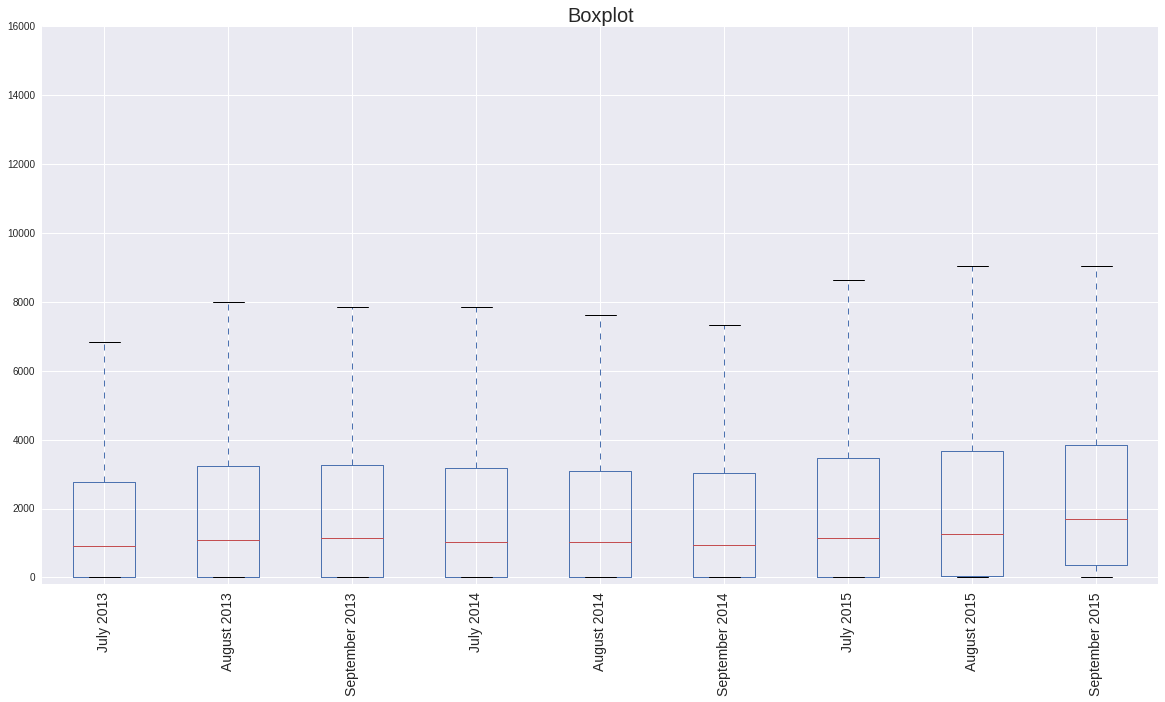

In [43]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (20,10))
#create a copy of the df for the viz purposes
summer_bike_monthly_ = summer_bike_monthly.copy()
summer_bike_monthly_.index = summer_bike_monthly_.index.strftime("%B %Y")
summer_bike_monthly_.T.boxplot(figsize = (15,7), ax = ax, rot = 90)

ax.set_title('Boxplot', size = 20)
ax.set_ylim([-200,16000])
plt.show()

**Figure 3:** 

In [ ]:
### Time Series Analysis - Winter

In [ ]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
winter_bike_monthly_ = winter_bike_monthly.copy()
winter_bike_monthly_.index = winter_bike_monthly_.index.strftime("%B %Y")
winter_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

In [ ]:
#Create a monthly time series of bike ride (Average of all citibike stations)
#df_new = bike_monthly_.mean(1).resample('M').mean()
#df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
#res = sm.tsa.seasonal_decompose(df_new.dropna())
#plt.rcParams['figure.figsize']=(12,8)
#resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [ ]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [ ]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

### Intersect the two geometries

In [ ]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

In [ ]:
station_id.BoroCT2010.head()

### Add Monthly rides to the station GeoDataFrame with CT code

In [ ]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [ ]:
station_id.head()

In [ ]:
##summer

In [ ]:
summer_station_id = station_id.copy()

In [ ]:
summer_station_id['MonthlyAve'] = summer_bike_monthly_.sum()

In [ ]:
summer_station_id.head()

In [ ]:
## winter

In [ ]:
winter_station_id = station_id.copy()

In [ ]:
winter_station_id['MonthlyAve'] = winter_bike_monthly_.sum()

In [ ]:
winter_station_id.head()

### Add the monthly average rides to the CT shapefile 

In [ ]:
# use the 
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

In [ ]:
## Summer

In [ ]:
temp_summer = summer_station_id[['MonthlyAve']]
temp_summer['station_id'] = summer_station_id.index
temp_summer.index = summer_station_id['BoroCT2010']
ct_shape_MonthlyAve_summer = ct_shape.join(temp_summer)
ct_shape_MonthlyAve_summer.fillna(0,inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_summer.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

In [ ]:
#Winter

In [ ]:
temp_winter = winter_station_id[['MonthlyAve']]
temp_winter['station_id'] = winter_station_id.index
temp_winter.index = winter_station_id['BoroCT2010']
ct_shape_MonthlyAve_winter = ct_shape.join(temp_winter)
ct_shape_MonthlyAve_winter.fillna(0,inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_winter.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [ ]:
# Summer

In [ ]:
ct_shape_MonthlyAve_summer_Zoom=(ct_shape_MonthlyAve_summer[ct_shape_MonthlyAve_summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [ ]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp_summer.MonthlyAve)

In [ ]:
# Winter

In [ ]:
ct_shape_MonthlyAve_winter_Zoom=(ct_shape_MonthlyAve_winter[ct_shape_MonthlyAve_winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [ ]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp_winter.MonthlyAve)

### Map the monthly rides 

In [ ]:
### Summer

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_summer_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

In [ ]:
## Winter

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_winter_Zoom.plot(column='MonthlyAve',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [ ]:
# Summer and Winter

In [ ]:
path_summer = 'Output/ct_shape_MonthlyAve_summer_Zoom.shp'
ct_shape_MonthlyAve_summer_Zoom.to_file(path_summer)

In [ ]:
path_winter = 'Output/ct_shape_MonthlyAve_winter_Zoom.shp'
ct_shape_MonthlyAve_winter_Zoom.to_file(path_winter)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [ ]:
# Summer

In [ ]:
qW_CT_summer = ps.queen_from_shapefile(path_summer)

In [ ]:
# winter

In [ ]:
qW_CT_winter = ps.queen_from_shapefile(path_winter)

#### Neighbors of index10

In [ ]:
#Summer

In [ ]:
qW_CT_summer[10]

In [ ]:
qW_CT_summer.cardinalities[10]

In [ ]:
# Winter

In [ ]:
qW_CT_winter[10]

In [ ]:
qW_CT_winter.cardinalities[10]

#### Matrix of Weights

In [ ]:
# Summer

In [ ]:
Wmatrix_summer, ids_summer = qW_CT_summer.full()

In [ ]:
Wmatrix_summer

In [ ]:
# Winter

In [ ]:
Wmatrix_winter, ids_winter = qW_CT_winter.full()

In [ ]:
Wmatrix_winter

#### Change the matrix to be row-standardized

In [ ]:
# Summer

In [ ]:
qW_CT_summer.transform = 'r'

In [ ]:
# Winter

In [ ]:
qW_CT_winter.transform = 'r'

### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [ ]:
# Summer

In [ ]:
MonthlyRide_summer = ct_shape_MonthlyAve_summer_Zoom.MonthlyAve
MonthlyRideLag_summer = ps.lag_spatial(qW_CT_summer, MonthlyRide_summer)

In [ ]:
# Winter

In [ ]:
MonthlyRide_winter = ct_shape_MonthlyAve_winter_Zoom.MonthlyAve
MonthlyRideLag_winter = ps.lag_spatial(qW_CT_winter, MonthlyRide_winter)

#### Create Quantiles for maping

In [ ]:
# Summer

In [ ]:
MonthlyRideLagQ10_summer = ps.Quantiles(MonthlyRideLag_summer, k=10)
MonthlyRideLagQ10_summer

In [ ]:
# Winter

In [ ]:
MonthlyRideLagQ10_winter = ps.Quantiles(MonthlyRideLag_winter, k=10)
MonthlyRideLagQ10_winter

#### Map the monthly rides lag

In [ ]:
# Summer

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_summer_Zoom.assign(cl=MonthlyRideLagQ10_summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles")

In [ ]:
# Winter

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_winter_Zoom.assign(cl=MonthlyRideLagQ10_winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation

In [ ]:
# Summer

In [ ]:
b,a = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b,a 

In [ ]:
# Winter

In [ ]:
b,a = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
b,a 

### Moran Scatterplot

In [ ]:
# Summer

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a + b*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot for summer rides')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('Summer MonthlyRides')

In [ ]:
# Winter

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a + b*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot for winter rides')
plt.ylabel('Spatial Lag of Winter MonthlyRides')
plt.xlabel('Winter MonthlyRides')

### Moran's I

In [ ]:
# Summer

In [ ]:
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT_summer)

In [ ]:
I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim

In [ ]:
print ('Thus, the I statistic is {:.2f} for this data, and has a very small p-value({}).'
       .format(I_MonthlyRide_summer.I,I_MonthlyRide_summer.p_sim))

In [ ]:
I_MonthlyRide_summer.sim[0:10]

In [ ]:
# Winter

In [ ]:
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT_winter)

In [ ]:
print ('Thus, the I statistic is {:.2f} for this data, and has a very small p-value({}).'
       .format(I_MonthlyRide_winter.I,I_MonthlyRide_winter.p_sim))

In [ ]:
I_MonthlyRide_winter.sim[0:10]

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [ ]:
plt.rcParams['figure.figsize']=(14,3)

In [ ]:
# Summer

In [ ]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

In [ ]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

In [ ]:
# Winter

In [ ]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

In [ ]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [ ]:
# Summer

In [ ]:
LMo_MonthlyRide_summer = ps.Moran_Local(MonthlyRide_summer, qW_CT_summer,permutations=999)

In [ ]:
LMo_MonthlyRide_summer.Is[0:5], LMo_MonthlyRide_summer.p_sim[0:5]

In [ ]:
# Winter

In [ ]:
LMo_MonthlyRide_winter = ps.Moran_Local(MonthlyRide_winter, qW_CT_winter,permutations=999)

In [ ]:
LMo_MonthlyRide_winter.Is[0:5], LMo_MonthlyRide_winter.p_sim[0:5]

### LISA (Local Indicators of Spatial Autocorrelation)

In [ ]:
# summer

In [ ]:
sigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim <= .001]
insigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim > .001]

In [ ]:
# winter

In [ ]:
sigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim <= .001]
insigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim > .001]

### Plot Signficant LISA

In [ ]:
# Summer

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_summer.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a + b*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('Summer MonthlyRides')

In [ ]:
# Winter

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_winter.I, x=120000, y=5000,fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a + b*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of winter MonthlyRides')
plt.xlabel('Winter MonthlyRides')

### Hot and Cold spots 

In [ ]:
# Summer

In [ ]:
sig_summer = LMo_MonthlyRide_summer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRide_summer.q==1 * sig_summer
coldspots_summer = LMo_MonthlyRide_summer.q==3 * sig_summer
print "Number of Hotspots:", hotspots_summer.sum()
print "Number of Coldspots:", coldspots_summer.sum()

In [ ]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_summer_Zoom.assign(cl=hotcold_summer).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

In [ ]:
# Winter

In [ ]:
sig_winter = LMo_MonthlyRide_winter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRide_winter.q==1 * sig_winter
coldspots_winter = LMo_MonthlyRide_winter.q==3 * sig_winter
print "Number of Hotspots:", hotspots_winter.sum()
print "Number of Coldspots:", coldspots_winter.sum()

In [ ]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_winter_Zoom.assign(cl=hotcold_winter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")